In [1]:
import os, sys
# add to path
sys.path.append("../..")

import attr
import datetime

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import seaborn

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_probability as tfp

import pandas as pd


In [2]:
import quandl

In [3]:
from filterflow.smc import SMC
from filterflow.base import State, StateSeries, DTYPE_TO_OBSERVATION_SERIES, DTYPE_TO_STATE_SERIES

from filterflow.observation.base import ObservationModelBase, ObservationSampler
from filterflow.observation.linear import LinearObservationSampler
from filterflow.transition.random_walk import RandomWalkModel
from filterflow.proposal import BootstrapProposalModel
from filterflow.proposal.auxiliary_proposal import AuxiliaryProposal

from filterflow.resampling.criterion import NeffCriterion, AlwaysResample, NeverResample
from filterflow.resampling.standard import SystematicResampler, MultinomialResampler
from filterflow.resampling.differentiable import RegularisedTransform, CorrectedRegularizedTransform
from filterflow.resampling.differentiable.ricatti.solver import RicattiSolver

from filterflow.resampling.base import NoResampling

from filterflow.state_space_model import StateSpaceModel

## Process data

In [4]:
quandl.ApiConfig.api_key = os.environ['QUANDL_KEY']

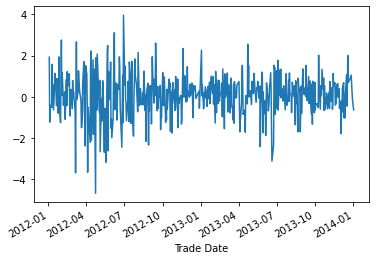

In [5]:
d =  quandl.get("NASDAQOMX/OMXS30", start_date="2012-01-02", end_date="2014-01-02")
y = np.log(d['Index Value']).diff()[1:] * 100
y.plot()

References:
- [Towards Smooth Particle Filters for
Likelihood Estimation with
Multivariate Latent Variables
](https://www.cs.ubc.ca/grads/resources/thesis/Nov08/Lee_Anthony.pdf)

Basic Model

$y_t \sim \mathcal{N}(\mathbf{B}\mathbf{f}_t, \mathbf{\Psi})$

$\mathbf{f}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{H}_t)$

$\mathbf{\alpha}_t \sim \mathcal{N}(\mathbf{\Phi}\mathbf{\alpha}_{t-1}, \mathbf{U})$

$\mathbf{\Psi} = \text{diag}(\psi_1, \ldots, \psi_M)$

$\mathbf{H}_t = \text{diag}(\exp(\mathbf{\alpha}_t))$

$\mathbf{\Phi} = \text{diag}(\phi_1, \ldots, \phi_M)$

For identifiability let:

$\mathbf{B} = \begin{bmatrix}
                     1   & 0   & 0   \\
                     0.5 & 1   & 0   \\
                     0.5 & 0.5 & 1   \\
                     0.2 & 0.6 & 0.3 \\
                     0.8 & 0.7 & 0.5
                \end{bmatrix}
$
$\hspace{2cm}$ 
$\mathbf{U} = \begin{bmatrix}
                    0.5 & 0.2 & 0.1 \\
                    0.2 & 0.5 & 0.2 \\
                    0.1 & 0.2 & 0.5
\end{bmatrix}$

In [6]:
K = 3
M = 5
T = 100

In [7]:
# Variables to train
B_init = np.array([[1., 0., 0,], 
                  [0.5, 1., 0.],
                  [0.5, 0.5, 1.],
                  [0.2, 0.6, 0.3],
                  [0.8, 0.7, 0.5]])

U_init = np.array([[0.5, 0.2, 0.1], 
                  [0.2, 0.5, 0.2],
                  [0.1, 0.2, 0.5]])

phi_init = np.repeat(0.9, K)
psi_init = np.repeat(0.5, M)

In [8]:
Bt = tf.constant(B_init, dtype=float)
Ut = tf.constant(U_init, dtype=float)
phit = tf.constant(phi_init, dtype=float)
psit = tf.constant(psi_init, dtype=float)

## Transition

In [9]:
zeros_k = tf.zeros(K, dtype=float)
chol_transition_cov = tf.linalg.cholesky(Ut)
transition_noise = tfp.distributions.MultivariateNormalTriL(zeros_k, chol_transition_cov)
transition_matrix = tf.linalg.diag(phit)
transition_model = RandomWalkModel(transition_matrix, transition_noise)

## Observation Model

In [10]:
zeros_m = tf.zeros(M, dtype=float)

B = Bt
psi = psit


Psi = tf.linalg.diag(psi)

class SVObservationModel(ObservationSampler):
    
    def generate_dist(self, state):
        alpha = state.particles
        H = tf.linalg.diag(tf.exp(alpha))
        
        Cov = B @ H @ tf.transpose(B) + Psi
        cov_chol = tf.linalg.cholesky(Cov)
        
        obs_dist = tfp.distributions.MultivariateNormalTriL(zeros_m, cov_chol)
        
        return obs_dist

    def loglikelihood(self, state: State, observation: tf.Tensor):
        """Computes the loglikelihood of an observation given proposed particles
        :param state: State
            Proposed (predicted) state of the filter given State at t-1 and Observation
        :param observation: ObservationBase
            User/Process given observation
        :return: a tensor of loglikelihoods for all particles
        :rtype: tf.Tensor
        """
        
        obs_dist = self.generate_dist(state)
        log_prob = obs_dist.log_prob(observation)
        return tf.reshape(log_prob, [batch_size, n_particles])

    def sample(self, state: State):
        """Samples a new observation conditionally on latent state
        :param state: State
            State of the filter at t
        :return: observartion 
        :rtype: Observation
        """
        
        obs_dist = self.generate_dist(state)
        observation = obs_dist.sample()
        
        return observation
        

In [11]:
observation_model = SVObservationModel()

## State Space Model

In [12]:
initial_value = zeros_k
ss_model = StateSpaceModel(observation_model=observation_model, transition_model=transition_model)
states, observations = ss_model(initial_value, T)

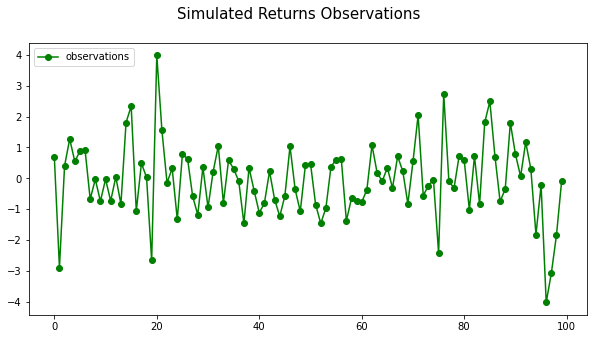

In [13]:
np_obs = np.array([observations[t].numpy().squeeze() for t in range(T)])
np_states = np.array([states[t].particles.numpy().squeeze() for t in range(T)])

linspace  = np.arange(T)
fig, axes = plt.subplots(nrows=1, figsize=(10, 5))
axes.plot(linspace, np_obs[:,0], marker='o', color='g', label='observations')
_ = axes.legend(loc='upper left')
_ = fig.suptitle('Simulated Returns Observations', fontsize=15)

In [14]:
obs_data = tf.data.Dataset.from_tensor_slices(observations)

## Particle Filter

In [15]:
# store observations
batch_size = 1
n_particles = 100
dimension = K

In [16]:
# initial state
normal_dist = tfp.distributions.Normal(0., 1.)
initial_particles = tf.zeros([batch_size, n_particles, dimension])

initial_particles = tf.cast(initial_particles, dtype=float)

initial_weights = tf.ones((batch_size, n_particles), dtype=float) / tf.cast(n_particles, float)
log_likelihoods = tf.zeros(batch_size, dtype=float)
initial_state = State(particles=initial_particles, 
                      log_weights = tf.math.log(initial_weights),
                      weights=initial_weights, 
                      log_likelihoods=log_likelihoods)

# proposal
proposal_model = BootstrapProposalModel(transition_model)

In [17]:
# resampling
resampling_criterion = NeffCriterion(tf.constant(0.5), tf.constant(True))
systematic = SystematicResampler()
multinomial = MultinomialResampler()


epsilon = tf.constant(0.25)
scaling = tf.constant(0.9)

regularized = RegularisedTransform(epsilon, scaling=scaling, max_iter=1000, convergence_threshold=1e-4)

In [18]:
particle_filter = SMC(observation_model, transition_model, proposal_model, resampling_criterion, regularized)

recorded_states = particle_filter(initial_state, observation_series=obs_data, n_observations=T)

recorded_states  = attr.evolve(recorded_states)

ht = np.array([state.particles.numpy() for state in states]).squeeze()

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


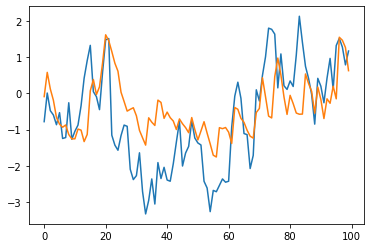

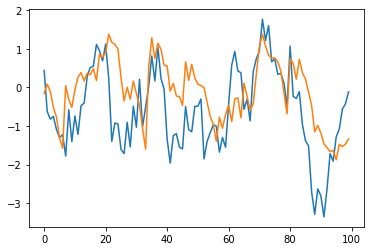

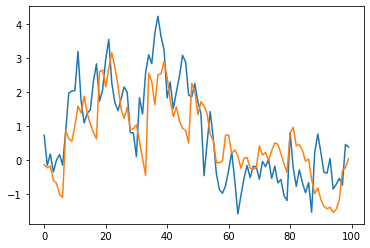

In [19]:
for i in range(K):
    
    # compute states
    computed_states = []
    for t, observation in enumerate(observations):
        state = recorded_states.read(tf.constant(t, dtype=tf.int32))
        log_weights = state.log_weights.numpy()
        particles = state.particles.numpy()[:,:,i]
        weights = np.exp(log_weights)
        computed_state = np.sum((weights * particles), axis=1)
        computed_states.append(computed_state)

    computed_states = np.array(computed_states).flatten()

    plt.plot(ht[:,i])
    plt.plot(computed_states)
    plt.show()

## Learn Param

In [20]:
# store observations
batch_size = 1
n_particles = 100
dimension = K

In [21]:
# initial state
normal_dist = tfp.distributions.Normal(0., 1.)
initial_particles = tf.zeros([batch_size, n_particles, dimension])

initial_particles = tf.cast(initial_particles, dtype=float)

initial_weights = tf.ones((batch_size, n_particles), dtype=float) / tf.cast(n_particles, float)
log_likelihoods = tf.zeros(batch_size, dtype=float)
initial_state = State(particles=initial_particles, 
                      log_weights = tf.math.log(initial_weights),
                      weights=initial_weights, 
                      log_likelihoods=log_likelihoods)

transition_matrix_init = tf.linalg.diag(tf.constant(np.repeat(0.5, K), dtype=float))
learnable_transition_matrix = tf.Variable(transition_matrix_init, trainable=True)


zeros_k = tf.zeros(K, dtype=float)
chol_transition_cov = tf.linalg.cholesky(Ut)
transition_noise = tfp.distributions.MultivariateNormalTriL(zeros_k, chol_transition_cov)
learn_transition_model = RandomWalkModel(learnable_transition_matrix, transition_noise)

# proposal
proposal_model = BootstrapProposalModel(learn_transition_model)

In [22]:
# resampling
resampling_criterion = NeffCriterion(tf.constant(0.5), tf.constant(True))
systematic = SystematicResampler()
multinomial = MultinomialResampler()


epsilon = tf.constant(0.25)
scaling = tf.constant(0.9)

regularized = RegularisedTransform(epsilon, scaling=scaling, max_iter=1000, convergence_threshold=1e-4)

In [23]:
particle_filter = SMC(observation_model, learn_transition_model, proposal_model, resampling_criterion, regularized)
recorded_states = particle_filter(initial_state, observation_series=obs_data, n_observations=T)
recorded_states  = attr.evolve(recorded_states)


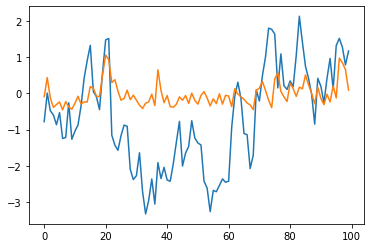

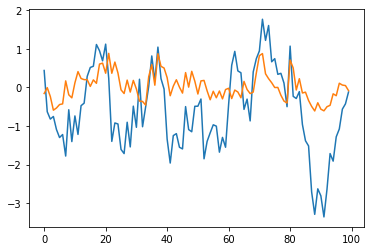

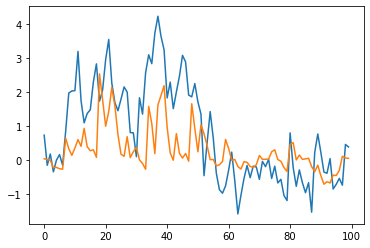

In [24]:
ht = np.array([state.particles.numpy() for state in states]).squeeze() # true states
for i in range(K):
    
    # compute states
    computed_states = []
    for t, observation in enumerate(observations):
        state = recorded_states.read(tf.constant(t, dtype=tf.int32))
        log_weights = state.log_weights.numpy()
        particles = state.particles.numpy()[:,:,i]
        weights = np.exp(log_weights)
        computed_state = np.sum((weights * particles), axis=1)
        computed_states.append(computed_state)

    computed_states = np.array(computed_states).flatten()

    plt.plot(ht[:,i])
    plt.plot(computed_states)
    plt.show()

In [25]:
# Create an optimizer.
optimizer = tf.optimizers.Adam(learning_rate=0.01)
tqdm_callback = tfa.callbacks.TQDMProgressBar()

@tf.function
def loss_func(smc):
    tf.random.set_seed(75)
    final_state = smc(initial_state, observation_series=obs_data, n_observations=T, return_final=True)
    return -tf.reduce_mean(final_state.log_likelihoods), tf.math.reduce_std(final_state.log_likelihoods)

@tf.function
def train_one_step(optimizer, smc):
    var_list= [learnable_transition_matrix]
    with tf.GradientTape() as tape:
        tape.watch(var_list)
        loss, _ = loss_func(smc)
    grads = tape.gradient(loss, var_list)
    clip = lambda val: tf.clip_by_value(val, -100., 100.)
    grads = [clip(grad) for grad in grads]
    optimizer.apply_gradients(zip(grads,var_list))
    return loss, grads

@tf.function
def train(optimizer, smc, num_steps = 101):
    assign_1 = learnable_transition_matrix.assign(transition_matrix_init)
    loss_tensor_array = tf.TensorArray(dtype=tf.float32, size=num_steps, dynamic_size=False, element_shape=[])
    grad_tensor_array = tf.TensorArray(dtype=tf.float32, size=num_steps, dynamic_size=False, element_shape=[])
    with tf.control_dependencies([assign_1]):
        for step in tf.range(num_steps):
            loss, grads = train_one_step(optimizer, smc)
            tf.print('Step', step, '/', num_steps - 1, ': loss = ', loss, end='\r')
            
            loss_tensor_array = loss_tensor_array.write(step, loss)
            grad_tensor_array = grad_tensor_array.write(step, tf.reduce_max(tf.abs(grads)))
    
    return (loss_tensor_array.stack(), grad_tensor_array.stack(), 
            tf.convert_to_tensor(learnable_transition_matrix))
            

In [26]:
pf_loss, pf_grad, pf_learned_transition_matrix = train(optimizer, particle_filter, num_steps=100)

In [27]:
learnable_transition_matrix

<tf.Variable 'Variable:0' shape=(3, 3) dtype=float32, numpy=
array([[ 0.6686659 , -0.07354259, -0.20985202],
       [ 0.03657139,  0.53517336,  0.13290147],
       [-0.26879838,  0.28045368,  0.84328395]], dtype=float32)>